In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('Dataset_Ads.csv')

# Initial inspection
print("Data shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nDescriptive statistics:")
print(df.describe())
print("\nMissing values:")
print(df.isnull().sum())

Data shape: (10000, 11)

First 5 rows:
   Age  Gender    Income  Location Ad Type Ad Topic   Ad Placement  Clicks  \
0   61    Male  35717.43     Urban  Banner   Travel   Social Media       3   
1   41    Male  47453.25     Rural   Video   Travel  Search Engine       5   
2   49  Female  68126.35     Rural    Text     Food   Social Media       4   
3   68  Female  64585.73  Suburban    Text   Health        Website       6   
4   63    Male  21109.40     Urban  Native  Fashion  Search Engine       5   

                   Click Time  Conversion Rate     CTR  
0  2024-01-18 20:45:56.898459           0.0981  0.0737  
1  2023-04-24 20:45:56.898459           0.0937  0.0592  
2  2024-02-24 20:45:56.898459           0.1912  0.0563  
3  2023-12-13 20:45:56.898459           0.1122  0.0232  
4  2023-07-02 20:45:56.898459           0.1426  0.0539  

Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null

In [2]:
# Handle negative ages and incomes
df = df[(df['Age'] > 0) & (df['Income'] > 0)]

# Check for missing values
print("Missing values after cleaning negatives:")
print(df.isnull().sum())

# Handle any remaining missing values if they exist
# For example, if there were missing values in 'CTR':
# df['CTR'].fillna(df['CTR'].median(), inplace=True)

# Convert 'Click Time' to datetime if needed
df['Click Time'] = pd.to_datetime(df['Click Time'])

# Handle outliers in key metrics
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Cap outliers instead of removing them
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

# Apply to numerical columns that might have outliers
numerical_cols = ['Age', 'Income', 'Clicks', 'Conversion Rate', 'CTR']
for col in numerical_cols:
    df = handle_outliers(df, col)

print("\nDescriptive statistics after outlier handling:")
print(df[numerical_cols].describe())

Missing values after cleaning negatives:
Age                0
Gender             0
Income             0
Location           0
Ad Type            0
Ad Topic           0
Ad Placement       0
Clicks             0
Click Time         0
Conversion Rate    0
CTR                0
dtype: int64

Descriptive statistics after outlier handling:
               Age         Income       Clicks  Conversion Rate          CTR
count  9822.000000    9822.000000  9822.000000      9822.000000  9822.000000
mean     34.617135   50447.257221     5.013337         0.201538     0.050373
std      14.253359   19342.663053     2.214223         0.119043     0.019733
min       1.000000     165.210000     0.000000         0.001000     0.000000
25%      25.000000   37171.157500     3.000000         0.109275     0.037100
50%      34.000000   50278.030000     5.000000         0.180400     0.050300
75%      44.000000   63374.047500     6.000000         0.275100     0.063700
max      72.500000  102678.382500    10.500000     

In [3]:
# Bucket continuous variables
# Age buckets
df['Age_Group'] = pd.cut(df['Age'],
                        bins=[0, 18, 25, 35, 45, 55, 65, 100],
                        labels=['0-18', '19-25', '26-35', '36-45', '46-55', '56-65', '66+'])

# Income quantile buckets
df['Income_Group'] = pd.qcut(df['Income'],
                            q=4,
                            labels=['Low', 'Medium', 'High', 'Very High'])

# Create interaction terms
df['Age_AdType'] = df['Age'].astype(str) + "_" + df['Ad Type']
df['Income_AdPlacement'] = df['Income_Group'].astype(str) + "_" + df['Ad Placement']

# Time-based features from Click Time
df['Click_DayOfWeek'] = df['Click Time'].dt.dayofweek
df['Click_Hour'] = df['Click Time'].dt.hour
df['Click_Month'] = df['Click Time'].dt.month

# Create binary flags for high performance
median_ctr = df['CTR'].median()
median_conversion = df['Conversion Rate'].median()
df['High_CTR'] = (df['CTR'] > median_ctr).astype(int)
df['High_Conversion'] = (df['Conversion Rate'] > median_conversion).astype(int)

# One-hot encode categorical variables
categorical_cols = ['Gender', 'Location', 'Ad Type', 'Ad Topic', 'Ad Placement', 
                   'Age_Group', 'Income_Group']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Drop original columns we've transformed
df.drop(['Click Time'], axis=1, inplace=True)

# Final check
print("\nFinal data shape:", df.shape)
print("\nFirst 5 rows after feature engineering:")
print(df.head())


Final data shape: (9822, 35)

First 5 rows after feature engineering:
    Age    Income  Clicks  Conversion Rate     CTR   Age_AdType  \
0  61.0  35717.43     3.0           0.0981  0.0737  61.0_Banner   
1  41.0  47453.25     5.0           0.0937  0.0592   41.0_Video   
2  49.0  68126.35     4.0           0.1912  0.0563    49.0_Text   
3  68.0  64585.73     6.0           0.1122  0.0232    68.0_Text   
4  63.0  21109.40     5.0           0.1426  0.0539  63.0_Native   

       Income_AdPlacement  Click_DayOfWeek  Click_Hour  Click_Month  ...  \
0        Low_Social Media                3          20            1  ...   
1    Medium_Search Engine                0          20            4  ...   
2  Very High_Social Media                5          20            2  ...   
3       Very High_Website                2          20           12  ...   
4       Low_Search Engine                6          20            7  ...   

   Ad Placement_Website  Age_Group_19-25  Age_Group_26-35  Age_Group_

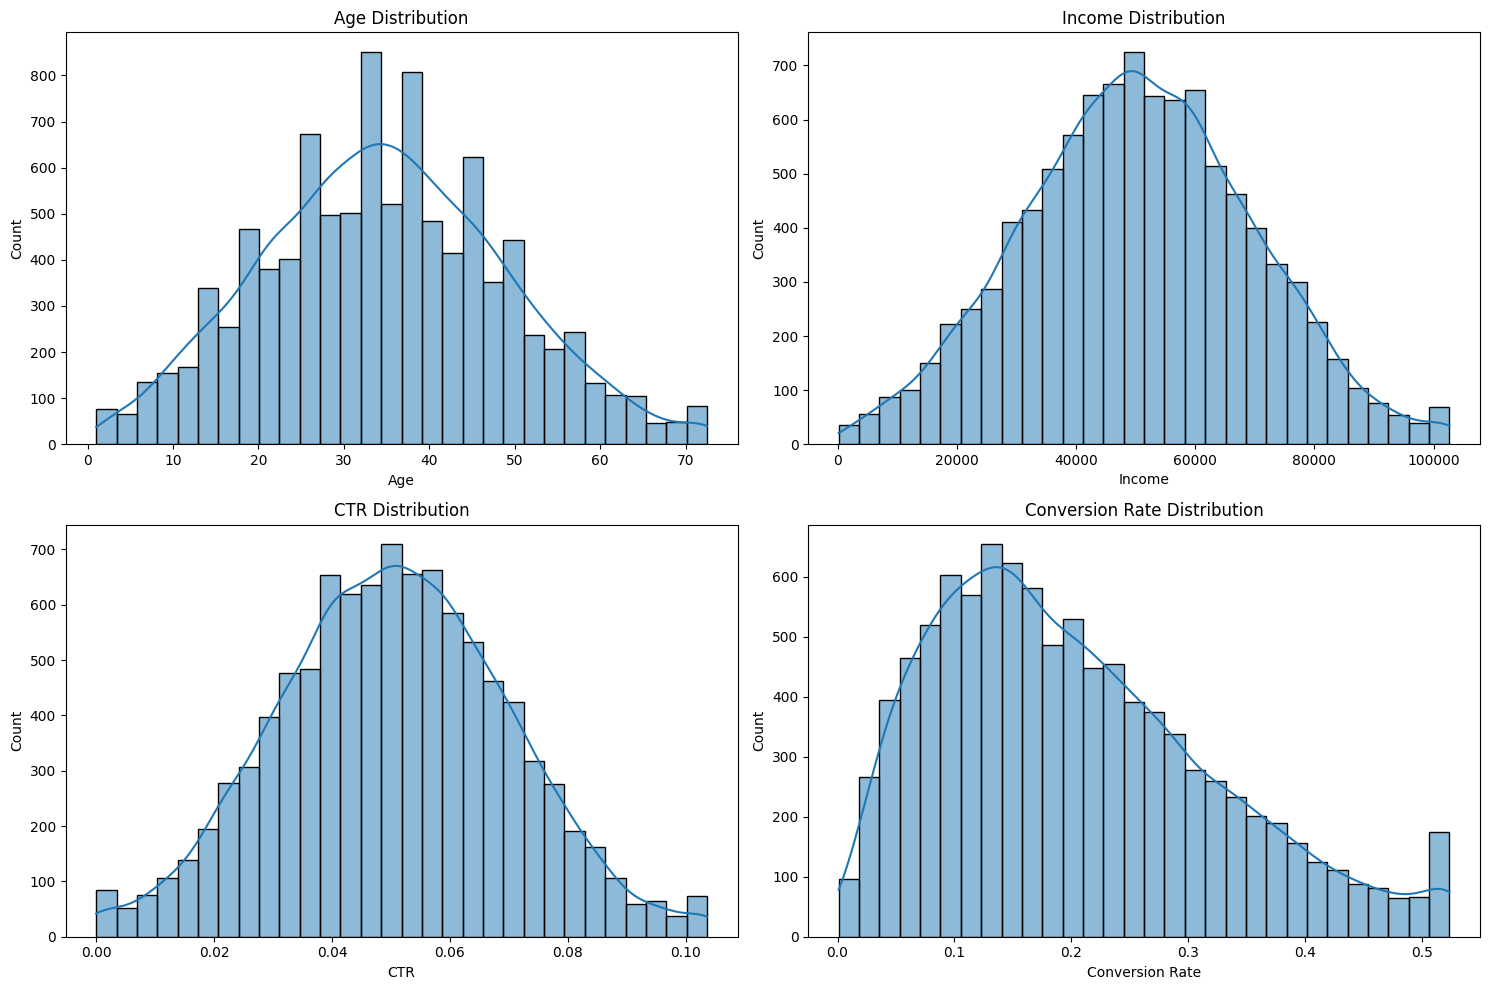

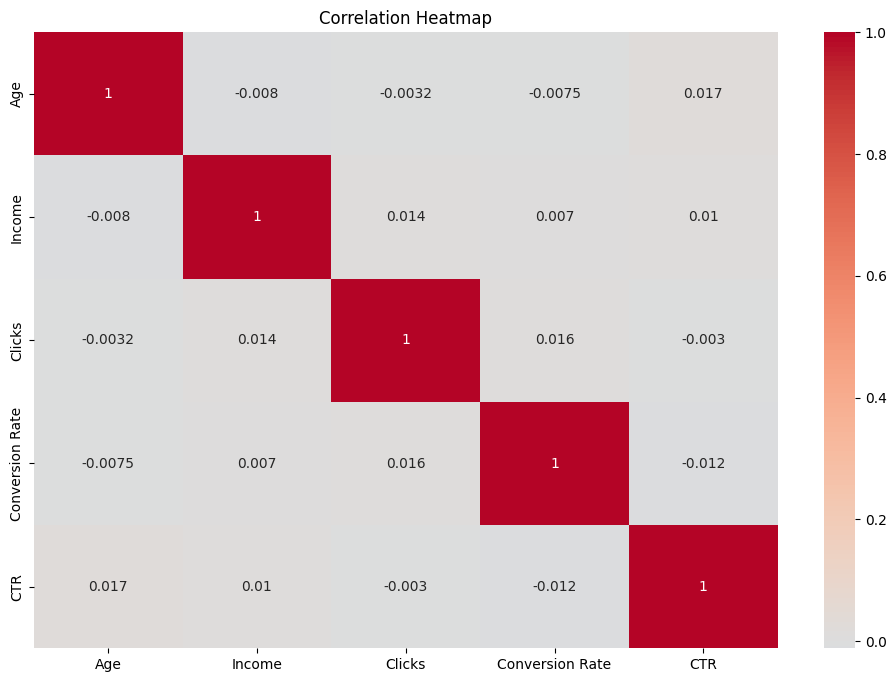

In [4]:
# Visualize the distributions after cleaning
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(df['Age'], bins=30, kde=True)
plt.title('Age Distribution')

plt.subplot(2, 2, 2)
sns.histplot(df['Income'], bins=30, kde=True)
plt.title('Income Distribution')

plt.subplot(2, 2, 3)
sns.histplot(df['CTR'], bins=30, kde=True)
plt.title('CTR Distribution')

plt.subplot(2, 2, 4)
sns.histplot(df['Conversion Rate'], bins=30, kde=True)
plt.title('Conversion Rate Distribution')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
corr = df[numerical_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

In [5]:
# Save cleaned data for modeling
df.to_csv('Cleaned_Ad_Data.csv', index=False)
print("Cleaned data saved to 'Cleaned_Ad_Data.csv'")

Cleaned data saved to 'Cleaned_Ad_Data.csv'


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
df = pd.read_csv("Cleaned_Ad_Data.csv")

# Display first few rows
print(df.head())

    Age    Income  Clicks  Conversion Rate     CTR   Age_AdType  \
0  61.0  35717.43     3.0           0.0981  0.0737  61.0_Banner   
1  41.0  47453.25     5.0           0.0937  0.0592   41.0_Video   
2  49.0  68126.35     4.0           0.1912  0.0563    49.0_Text   
3  68.0  64585.73     6.0           0.1122  0.0232    68.0_Text   
4  63.0  21109.40     5.0           0.1426  0.0539  63.0_Native   

       Income_AdPlacement  Click_DayOfWeek  Click_Hour  Click_Month  ...  \
0        Low_Social Media                3          20            1  ...   
1    Medium_Search Engine                0          20            4  ...   
2  Very High_Social Media                5          20            2  ...   
3       Very High_Website                2          20           12  ...   
4       Low_Search Engine                6          20            7  ...   

   Ad Placement_Website  Age_Group_19-25  Age_Group_26-35  Age_Group_36-45  \
0                 False            False            False     

  Ad Type   Avg CTR  Avg Conversion Rate  Avg Clicks
0  Native  0.050339             0.204248    5.064696
1    Text  0.050175             0.200755    5.043046
2   Video  0.050579             0.201926    4.961352


C:\Users\hp\AppData\Local\Temp\ipykernel_21892\3367776247.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ad_perf_df, x='Ad Type', y='Avg Conversion Rate', palette='viridis')


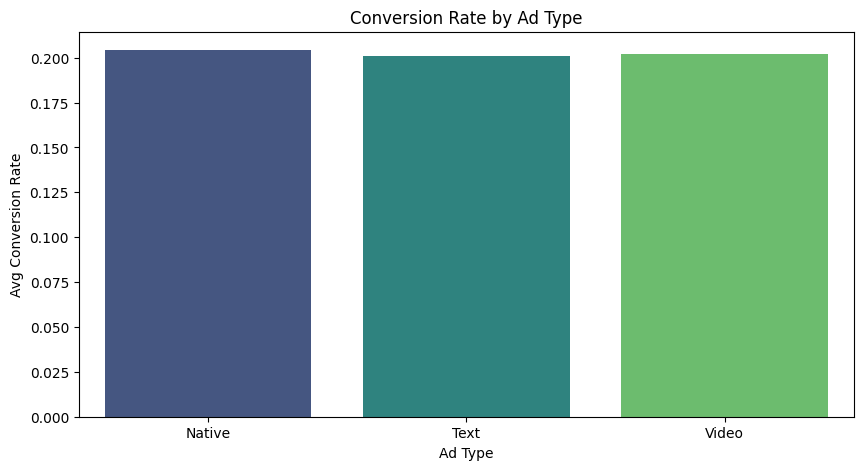

In [8]:
# Extract ad types that actually exist in your data
ad_types = ['Ad Type_Native', 'Ad Type_Text', 'Ad Type_Video']
ad_performance = []

for ad in ad_types:
    subset = df[df[ad] == True]
    avg_ctr = subset['CTR'].mean()
    avg_conversion = subset['Conversion Rate'].mean()
    avg_clicks = subset['Clicks'].mean()
    ad_performance.append({
        'Ad Type': ad.replace('Ad Type_', ''),
        'Avg CTR': avg_ctr,
        'Avg Conversion Rate': avg_conversion,
        'Avg Clicks': avg_clicks
    })

ad_perf_df = pd.DataFrame(ad_performance)
print(ad_perf_df)

# Plotting
plt.figure(figsize=(10, 5))
sns.barplot(data=ad_perf_df, x='Ad Type', y='Avg Conversion Rate', palette='viridis')
plt.title("Conversion Rate by Ad Type")
plt.show()

        Topic   Avg CTR  Avg Conversion Rate  Avg Clicks
0     Finance  0.049582             0.200377    5.032647
1        Food  0.051064             0.206801    4.995684
2      Health  0.050784             0.197697    4.991239
3  Technology  0.050371             0.198743    5.059275
4      Travel  0.050410             0.203008    5.060901


C:\Users\hp\AppData\Local\Temp\ipykernel_21892\3916740188.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topic_perf_df, x='Topic', y='Avg Conversion Rate', palette='magma')


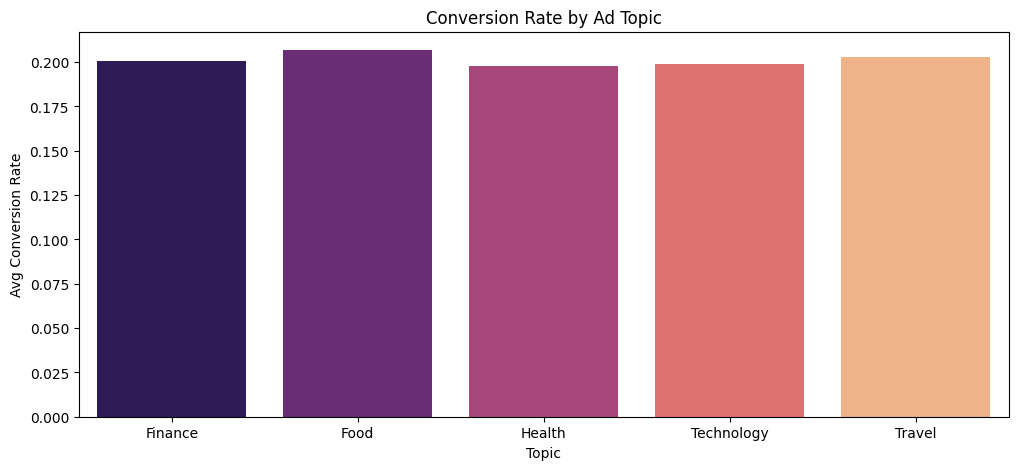

In [9]:
# Extract ad topics (Finance, Food, Health, Technology, Travel)
topics = ['Ad Topic_Finance', 'Ad Topic_Food', 'Ad Topic_Health', 'Ad Topic_Technology', 'Ad Topic_Travel']
topic_performance = []

for topic in topics:
    subset = df[df[topic] == True]
    avg_ctr = subset['CTR'].mean()
    avg_conversion = subset['Conversion Rate'].mean()
    avg_clicks = subset['Clicks'].mean()
    topic_performance.append({
        'Topic': topic.replace('Ad Topic_', ''),
        'Avg CTR': avg_ctr,
        'Avg Conversion Rate': avg_conversion,
        'Avg Clicks': avg_clicks
    })

topic_perf_df = pd.DataFrame(topic_performance)
print(topic_perf_df)

# Plotting
plt.figure(figsize=(12, 5))
sns.barplot(data=topic_perf_df, x='Topic', y='Avg Conversion Rate', palette='magma')
plt.title("Conversion Rate by Ad Topic")
plt.show()


Available placement columns: ['Income_AdPlacement', 'Ad Placement_Social Media', 'Ad Placement_Website']

Placement Performance:
                   Placement   Avg CTR  Avg Conversion Rate  Avg Clicks
0  Ad Placement Social Media  0.050617             0.204126    5.063603
1       Ad Placement Website  0.050140             0.201318    4.964591


C:\Users\hp\AppData\Local\Temp\ipykernel_21892\2262368607.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=placement_perf_df, x='Placement', y='Avg Conversion Rate', palette='rocket')


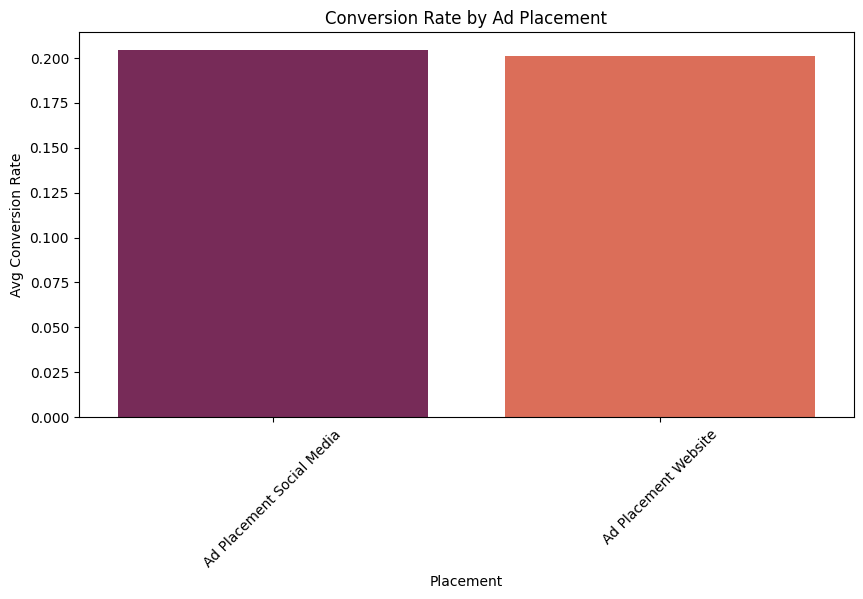

In [11]:
# Get all ad placement columns (they might be named differently)
placement_cols = [col for col in df.columns if 'Placement' in col]
print("\nAvailable placement columns:", placement_cols)

# Now analyze performance for each placement type
placement_performance = []

for placement in placement_cols:
    subset = df[df[placement] == True]
    if len(subset) > 0:  # Only proceed if there are records
        avg_ctr = subset['CTR'].mean()
        avg_conversion = subset['Conversion Rate'].mean()
        avg_clicks = subset['Clicks'].mean()
        
        placement_performance.append({
            'Placement': placement.replace('AdPlacement_', '').replace('Ad_Placement_', '').replace('_', ' '),
            'Avg CTR': avg_ctr,
            'Avg Conversion Rate': avg_conversion,
            'Avg Clicks': avg_clicks
        })

placement_perf_df = pd.DataFrame(placement_performance)
print("\nPlacement Performance:")
print(placement_perf_df)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(data=placement_perf_df, x='Placement', y='Avg Conversion Rate', palette='rocket')
plt.title("Conversion Rate by Ad Placement")
plt.xticks(rotation=45)
plt.show()

In [12]:
# Age Group Analysis
age_groups = ['Age_Group_19-25', 'Age_Group_26-35', 'Age_Group_36-45', 'Age_Group_46-55', 'Age_Group_56-65', 'Age_Group_66+']
age_performance = []

for age in age_groups:
    subset = df[df[age] == True]
    avg_ctr = subset['CTR'].mean()
    avg_conversion = subset['Conversion Rate'].mean()
    age_performance.append({
        'Age Group': age.replace('Age_Group_', ''),
        'Avg CTR': avg_ctr,
        'Avg Conversion Rate': avg_conversion
    })

age_perf_df = pd.DataFrame(age_performance)
print(age_perf_df)

# Income Group Analysis
income_groups = ['Income_Group_Medium', 'Income_Group_High', 'Income_Group_Very High']
income_performance = []

for income in income_groups:
    subset = df[df[income] == True]
    avg_ctr = subset['CTR'].mean()
    avg_conversion = subset['Conversion Rate'].mean()
    income_performance.append({
        'Income Group': income.replace('Income_Group_', ''),
        'Avg CTR': avg_ctr,
        'Avg Conversion Rate': avg_conversion
    })

income_perf_df = pd.DataFrame(income_performance)
print(income_perf_df)

  Age Group   Avg CTR  Avg Conversion Rate
0     19-25  0.049933             0.202490
1     26-35  0.050385             0.202462
2     36-45  0.050837             0.202197
3     46-55  0.050756             0.200406
4     56-65  0.049953             0.196254
5       66+  0.051313             0.197183
  Income Group   Avg CTR  Avg Conversion Rate
0       Medium  0.050509             0.201173
1         High  0.050543             0.198889
2    Very High  0.050356             0.203774


C:\Users\hp\AppData\Local\Temp\ipykernel_21892\166030007.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_df, x='Age Group', y='Avg CTR', palette='Blues')
C:\Users\hp\AppData\Local\Temp\ipykernel_21892\166030007.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=age_df, x='Age Group', y='Avg Conversion Rate', palette='Greens')
C:\Users\hp\AppData\Local\Temp\ipykernel_21892\166030007.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=income_df, x='Income Group', y='Avg CTR', palette='Oranges')
C:\Users\hp\AppData\Lo

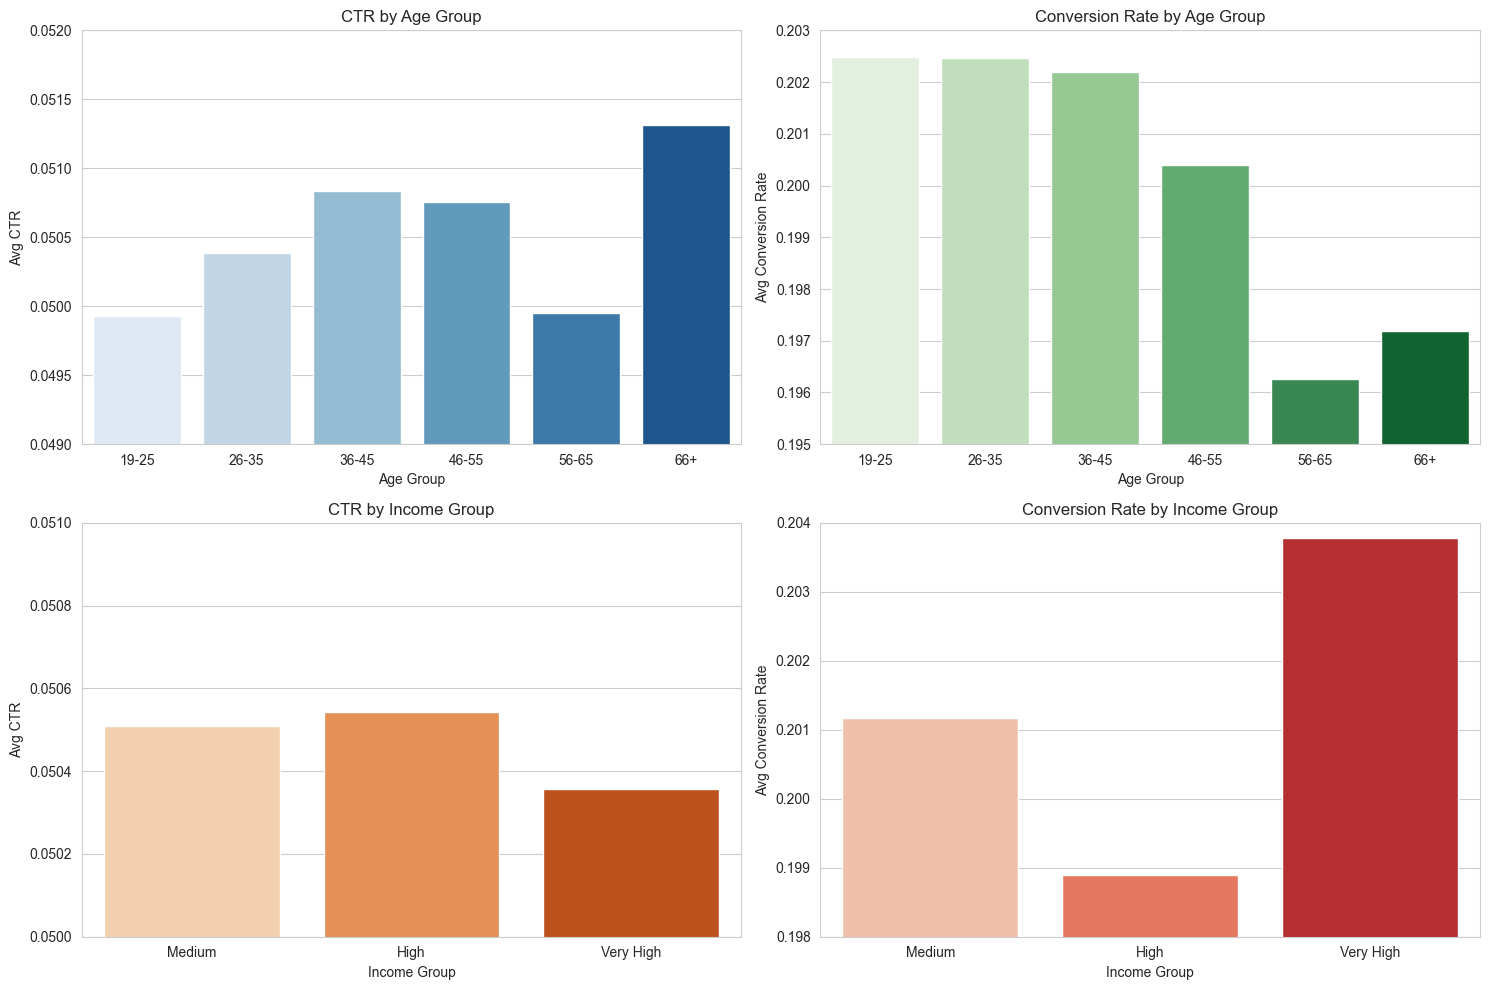

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Age Group Analysis
age_data = {
    'Age Group': ['19-25', '26-35', '36-45', '46-55', '56-65', '66+'],
    'Avg CTR': [0.049933, 0.050385, 0.050837, 0.050756, 0.049953, 0.051313],
    'Avg Conversion Rate': [0.202490, 0.202462, 0.202197, 0.200406, 0.196254, 0.197183]
}

# 2. Income Group Analysis
income_data = {
    'Income Group': ['Medium', 'High', 'Very High'],
    'Avg CTR': [0.050509, 0.050543, 0.050356],
    'Avg Conversion Rate': [0.201173, 0.198889, 0.203774]
}

# Create DataFrames
age_df = pd.DataFrame(age_data)
income_df = pd.DataFrame(income_data)

# Set style
sns.set_style("whitegrid")
plt.figure(figsize=(15, 10))

# 1. Age Group Visualization
plt.subplot(2, 2, 1)
sns.barplot(data=age_df, x='Age Group', y='Avg CTR', palette='Blues')
plt.title('CTR by Age Group')
plt.ylim(0.049, 0.052)

plt.subplot(2, 2, 2)
sns.barplot(data=age_df, x='Age Group', y='Avg Conversion Rate', palette='Greens')
plt.title('Conversion Rate by Age Group')
plt.ylim(0.195, 0.203)

# 2. Income Group Visualization
plt.subplot(2, 2, 3)
sns.barplot(data=income_df, x='Income Group', y='Avg CTR', palette='Oranges')
plt.title('CTR by Income Group')
plt.ylim(0.050, 0.051)

plt.subplot(2, 2, 4)
sns.barplot(data=income_df, x='Income Group', y='Avg Conversion Rate', palette='Reds')
plt.title('Conversion Rate by Income Group')
plt.ylim(0.198, 0.204)

plt.tight_layout()
plt.show()

In [16]:
print("\nAge Group Recommendations:")
print("1. Maintain broad targeting across all age groups (CTR is stable)")
print("2. Focus conversion optimization on 19-45 year olds (highest converters)")
print("3. Test different messaging for 46+ audiences to improve conversions")


Age Group Recommendations:
1. Maintain broad targeting across all age groups (CTR is stable)
2. Focus conversion optimization on 19-45 year olds (highest converters)
3. Test different messaging for 46+ audiences to improve conversions


In [17]:
print("\nIncome Group Recommendations:")
print("1. Very High income: Premium offerings with high-margin products")
print("2. Medium income: Volume strategy with mid-range products")
print("3. High income: Investigate why conversions are lower than Medium income")


Income Group Recommendations:
1. Very High income: Premium offerings with high-margin products
2. Medium income: Volume strategy with mid-range products
3. High income: Investigate why conversions are lower than Medium income


In [18]:
# Calculate performance differences
age_df['CTR Diff'] = age_df['Avg CTR'] - age_df['Avg CTR'].mean()
age_df['Conv Diff'] = age_df['Avg Conversion Rate'] - age_df['Avg Conversion Rate'].mean()

income_df['CTR Diff'] = income_df['Avg CTR'] - income_df['Avg CTR'].mean()
income_df['Conv Diff'] = income_df['Avg Conversion Rate'] - income_df['Avg Conversion Rate'].mean()

print("\nAge Group Performance Differences:")
print(age_df[['Age Group', 'CTR Diff', 'Conv Diff']])

print("\nIncome Group Performance Differences:")
print(income_df[['Income Group', 'CTR Diff', 'Conv Diff']])


Age Group Performance Differences:
  Age Group  CTR Diff  Conv Diff
0     19-25 -0.000596   0.002325
1     26-35 -0.000144   0.002297
2     36-45  0.000308   0.002032
3     46-55  0.000227   0.000241
4     56-65 -0.000577  -0.003911
5       66+  0.000783  -0.002982

Income Group Performance Differences:
  Income Group  CTR Diff  Conv Diff
0       Medium  0.000040  -0.000106
1         High  0.000074  -0.002390
2    Very High -0.000113   0.002495


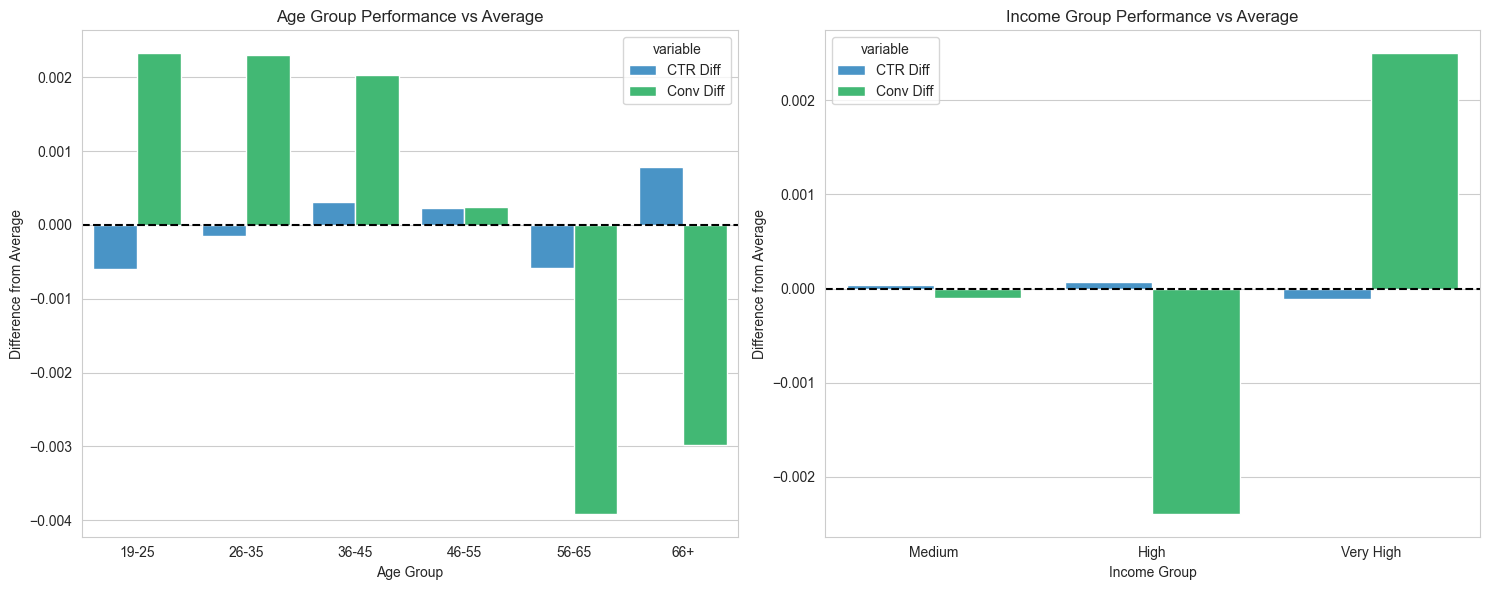

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation
age_diff = age_df[['Age Group', 'CTR Diff', 'Conv Diff']].melt(id_vars='Age Group')
income_diff = income_df[['Income Group', 'CTR Diff', 'Conv Diff']].melt(id_vars='Income Group')

# Visualization
plt.figure(figsize=(15, 6))

# Age Group Differences
plt.subplot(1, 2, 1)
sns.barplot(data=age_diff, x='Age Group', y='value', hue='variable', 
            palette={'CTR Diff': '#3498db', 'Conv Diff': '#2ecc71'})
plt.axhline(0, color='black', linestyle='--')
plt.title('Age Group Performance vs Average')
plt.ylabel('Difference from Average')

# Income Group Differences
plt.subplot(1, 2, 2)
sns.barplot(data=income_diff, x='Income Group', y='value', hue='variable',
            palette={'CTR Diff': '#3498db', 'Conv Diff': '#2ecc71'})
plt.axhline(0, color='black', linestyle='--')
plt.title('Income Group Performance vs Average')
plt.ylabel('Difference from Average')

plt.tight_layout()
plt.show()

Action Items for Optimization:

✓ A/B Test for 66+ age group:
  - Larger text/buttons
  - Simplified checkout process

✓ High Income Group Analysis:
  - Survey existing customers
  - Review competitor offerings

✓ 36-45 Age Group Capitalization:
  - Create dedicated campaign
  - Test bundling strategies

✓ Conversion Funnel Review:
  - Especially for 56-65 age group
  - Check mobile vs desktop differences

Income Group Strategies:
1. Very High Income:
   - Premium positioning with exclusivity messaging
   - Higher price points perform well here

2. High Income Investigation:
   - Audit customer journey for friction points
   - Check if offers match expectations of this group

3. Medium Income:
   - Reliable base - maintain current strategy
   - Good candidate for volume-based promotions